In [1]:
!pip install huggingface_hub

In [2]:
!pip install transformers

In [3]:
!pip install datasets==4.0.0 pyarrow==20.0.0 multiprocess==0.70.16 dill==0.3.8 

In [4]:
!pip install umap-learn

In [5]:
!pip install accelerate

In [66]:
import torch
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, DistilBertTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from torch.nn.functional import cross_entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

In [7]:
emotions = load_dataset("emotion")

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train_ds = emotions["train"]
print(len(train_ds))

16000


In [10]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [11]:
train_ds.column_names

['text', 'label']

In [12]:
train_ds.features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [13]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [14]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [16]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


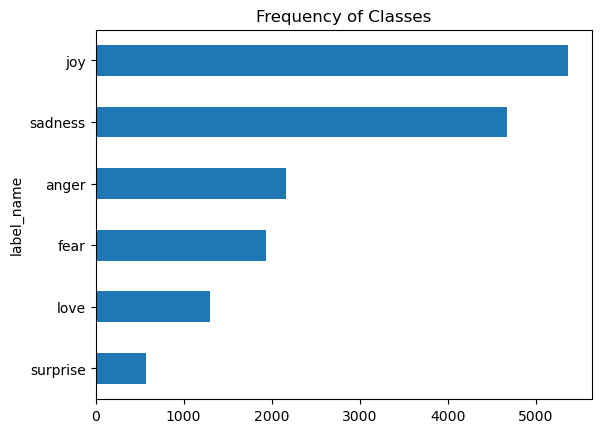

In [17]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

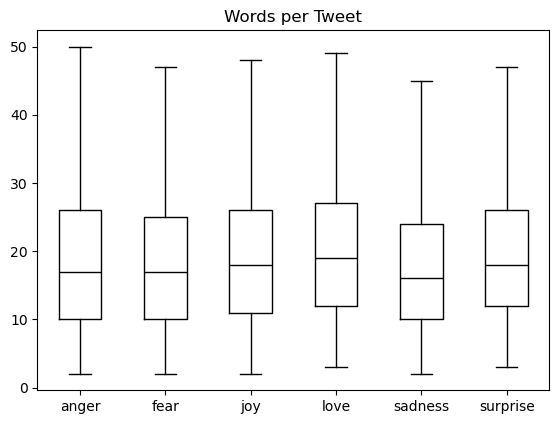

In [18]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False,
    showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [19]:
emotions.reset_format()

In [20]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [21]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [22]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [24]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [25]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [26]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [27]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [28]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [29]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [30]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shapes: {inputs['input_ids'].size()}") 

Input tensor shapes: torch.Size([1, 6])


In [31]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [32]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [33]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [34]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    #extract last hidden state
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [35]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [36]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [37]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### visualizing the training set

In [38]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.128680,4.152919,0
1,-2.995833,5.073784,0
2,5.501800,7.510678,3
3,-2.585328,7.533455,2
4,-3.141929,7.061733,3


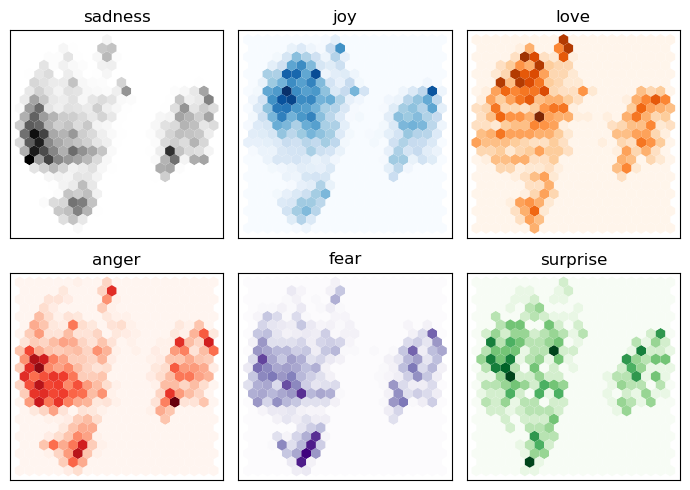

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"],df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [40]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [41]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [42]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    flg, ax = plt.subplots(figsize=(6,6,))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues" ,values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

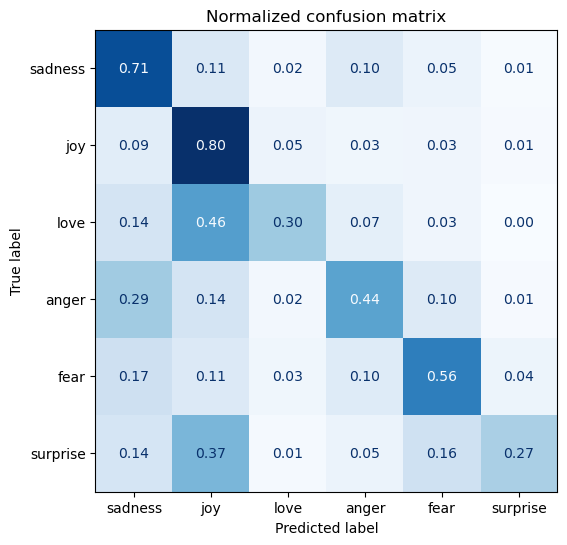

In [43]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [94]:
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [95]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [96]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error"
                                 )

In [97]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer
                 )
trainer.train()

/tmp/ipykernel_1932/485441048.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.806700,0.311307,0.907000,0.905909
2,0.252400,0.215890,0.924500,0.924513


TrainOutput(global_step=500, training_loss=0.5295237579345703, metrics={'train_runtime': 213.3919, 'train_samples_per_second': 149.959, 'train_steps_per_second': 2.343, 'total_flos': 720342861696000.0, 'train_loss': 0.5295237579345703, 'epoch': 2.0})

In [98]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.21588969230651855,
 'test_accuracy': 0.9245,
 'test_f1': 0.9245130130540814,
 'test_runtime': 3.3823,
 'test_samples_per_second': 591.318,
 'test_steps_per_second': 9.461}

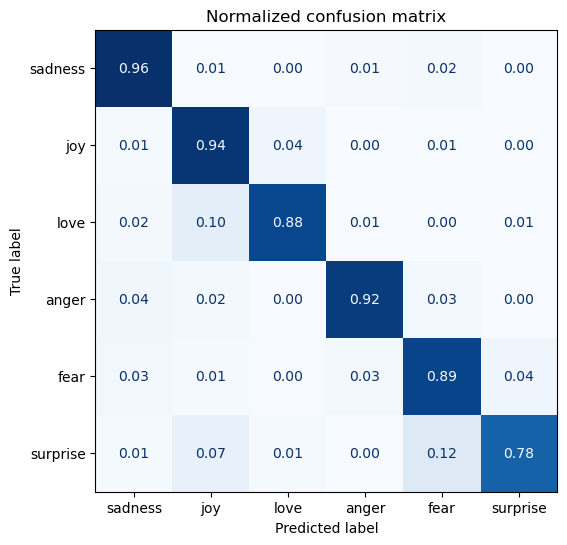

In [99]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [100]:
def forward_pass_with_label(batch):
    inputs={k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    return {"loss":loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()
           }

In [101]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded["validation"] = (emotions_encoded["validation"]
                                .map(forward_pass_with_label, batched=True, batch_size=16))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [102]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [103]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.645001
1963,i called myself pro life and voted for perry w...,joy,sadness,5.494765
1950,i as representative of everything thats wrong ...,surprise,sadness,5.407619
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.295640
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.089688
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.054059
1274,i am going to several holiday parties and i ca...,joy,sadness,4.990359
1801,i feel that he was being overshadowed by the s...,love,sadness,4.916700
1509,i guess this is a memoir so it feels like that...,joy,fear,4.902573
1111,im lazy my characters fall into categories of ...,joy,fear,4.385359


In [104]:
df_test.sort_values("loss",ascending=True).head(10)

,text,label,predicted_label,loss
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.016532
264,i am left feeling underwhelmed and ungrateful,sadness,sadness,0.016833
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.016840
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.016910
392,i remember feeling disheartened one day when w...,sadness,sadness,0.016932
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.016998
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017010
1120,i am feeling a little disheartened,sadness,sadness,0.017078
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017082
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017112


In [105]:
classifier = pipeline('text-classification', model=model_name)

In [106]:
custom_tweet="I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


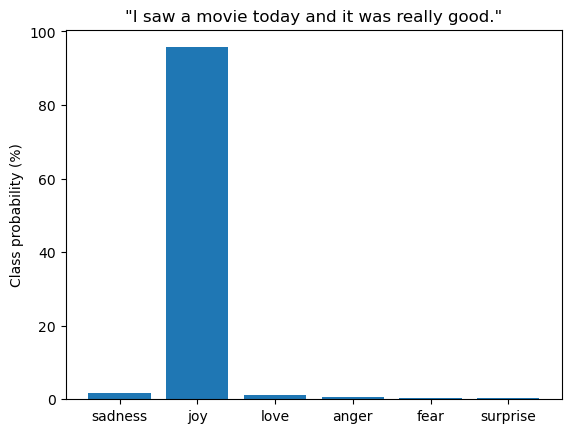

In [107]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel(f"Class probability (%)")
plt.show()

In [108]:
preds_df["score"]

0    0.016664
1    0.956777
2    0.011067
3    0.006436
4    0.004329
5    0.004727
Name: score, dtype: float64

In [109]:
100*preds_df["score"]

0     1.666423
1    95.677662
2     1.106734
3     0.643639
4     0.432875
5     0.472655
Name: score, dtype: float64

In [110]:
trainer.push_to_hub(commit_message="Training completed")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/grantbabb/distilbert-base-uncased-finetuned-emotion/commit/7bd0da2c69263f5914f1e155e7eb37a909372257', commit_message='Training completed', commit_description='', oid='7bd0da2c69263f5914f1e155e7eb37a909372257', pr_url=None, repo_url=RepoUrl('https://huggingface.co/grantbabb/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='grantbabb/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [111]:
preds

[[{'label': 'LABEL_0', 'score': 0.016664231196045876},
  {'label': 'LABEL_1', 'score': 0.9567766189575195},
  {'label': 'LABEL_2', 'score': 0.011067336425185204},
  {'label': 'LABEL_3', 'score': 0.006436389405280352},
  {'label': 'LABEL_4', 'score': 0.0043287500739097595},
  {'label': 'LABEL_5', 'score': 0.004726550541818142}]]

In [112]:
#trainer.push_to_hub(commit_message="Training completed.")